# Initialization

In [1]:
# Importing required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
%matplotlib notebook

In [2]:
# Reading the dataset
df = pd.read_csv('insurance.txt')

# Dropping 'children' column
df.drop(columns = 'children', inplace = True)

df.head()

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520


## Function to normalize dataset
### normalize_dataset function normalizes the dataset by using the formula
## $X_{normalized} = \frac {X - min(X_i)} {max(X_i) - min(X_i)}$

In [3]:
def normalize_dataset():

    # normalize_coeff stores max and min of every column in dataset for denormalization
    normalize_coeff = {col: {'max': df[col].max(), 'min': df[col].min()} for col in df.columns}

    # normal_df is the normalized dataframe
    normal_df = (df - df.min()) / (df.max() - df.min())

    return pd.DataFrame(normal_df), normalize_coeff

In [4]:
normal_df, normalize_coeff = normalize_dataset()

normal_df.head()

,age,bmi,charges
0,0.021739,0.321227,0.251611
1,0.000000,0.479150,0.009636
2,0.217391,0.458434,0.053115
3,0.326087,0.181464,0.333010
4,0.304348,0.347592,0.043816


## Function to shuffle the dataset and return $X_{train}, Y_{train}, X_{val}, Y_{val}, X_{test}, Y_{test}$ matrices 

In [5]:
from math import ceil
def shuffle(dataframe, train_ratio, val_ratio, target):
    
    # Getting list of columns for X matrix
    columns = list(dataframe.columns)
    columns.remove(target)
    
    # Getting the max indices for training and validation set
    train_idx = ceil(len(dataframe) * train_ratio)
    val_idx = ceil(len(dataframe) * (train_ratio + val_ratio))
    
    # Shuffling the dataset
    sf = dataframe.sample(frac = 1)
    
    # Dividing X and Y matrices
    X = sf[columns]
    Y = sf[target]
    
    # Generating train, validation and test sets
    X_train = X.iloc[:train_idx].to_numpy().reshape((-1, len(columns)))
    X_val = X.iloc[train_idx : val_idx].to_numpy().reshape((-1, len(columns)))
    X_test = X.iloc[val_idx:].to_numpy().reshape((-1, len(columns)))
    
    Y_train = Y.iloc[:train_idx].to_numpy().reshape((-1, 1))
    Y_val = Y.iloc[train_idx : val_idx].to_numpy().reshape((-1, 1))
    Y_test = Y.iloc[val_idx:].to_numpy().reshape((-1, 1))
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

## Function to initialize weights

In [6]:
def initialize_weights(X):
    num_features = X.shape[1]
    W = np.zeros((num_features, 1))
    return W

## Function to predict the results

In [7]:
def predict(W, X):
    predictions = X @ W         # '@' performs matrix multiplication
    return predictions

## Function to normalize a value

In [8]:
def normalize(value, name):
    nc = normalize_coeff[name]
    out = (value - nc['min']) / (nc['max'] - nc['min'])
    return out

## Function to denormalize a value

In [9]:
def denormalize(value, name):
    nc = normalize_coeff[name]
    out = value * (nc['max'] - nc['min']) + nc['min']
    return out

## Functions to calculate Error and Accuracy
### Metric used for error -> MSE
## $ MSE = \frac {\sum_{i=1}^{m}{(y_i - \hat y_i)^2}} {2m} $

In [10]:
def calculate_error(y, y_hat):
    y = y.flatten()
    y_hat = y_hat.flatten()
    sq_err = np.sum((y - y_hat) ** 2)
    mse = sq_err / (2 * len(y))
    return mse

### Metric used for accuracy -> $ R^2 $
## $ R^2 = 1- \frac {2 \times MSE} {Var(Y)} $

In [11]:
def calculate_accuracy(y, y_hat):
    y = y.flatten()
    y_hat = y_hat.flatten()
    mse = calculate_error(y, y_hat)
    var_y = np.var(y)
    rMSE = 2 * mse / var_y
    R2 = 1 - rMSE
    return R2

## Cost Function
### Lasso Cost = $ MSE + \frac {\lambda_1} {2m} \sum_{i=1}^M |W_i| $
### Ridge Cost = $ MSE + \frac {\lambda_2} {2m} \sum_{i=1}^M W_i^2 $

In [12]:
def calculate_cost(y, y_hat, W, lambda1 = 0, lambda2 = 0):
    mse = calculate_error(y, y_hat)
    reg1 = lambda1 / (2 * len(y)) * np.sum(np.abs(W))
    reg2 = lambda2 / (2 * len(y)) * (W.T @ W).flatten()[0]
    cost = mse + reg1 + reg2
    return cost

# Building Gradient Descent model
## Function for finding W using Gradient Descent

In [13]:
def gradient_descent(X, y, W, eta = 0.1, lambda1 = 0, lambda2 = 0, num_iterations = 2000):
    print_space = num_iterations // 5 if num_iterations > 5 else 1
    m = len(X)
    J = {}
    accuracy = {}
    for i in range(1, num_iterations + 1):
        dReg1 = lambda1 / (2 * m) * np.sign(W)
        dReg2 = (lambda2 / m) * W
        dW_old = (1 / m) * (X.T @ (X @ W - y))
        dW = dW_old + dReg1 + dReg2
        W = W - (eta * dW)
        prediction = predict(W, X)
        cost = calculate_cost(y, prediction, W, lambda1, lambda2)
        J[i] = cost
        acc = calculate_accuracy(y, prediction)
        accuracy[i] = acc
        if i == 1 or i % print_space == 0:
            print(f'Cost after {i} iterations is {cost}, accuracy = {acc}')
    return W, J, accuracy

## Applying Gradient Descent

In [14]:
# Initializing important variables
W_gd = {}
train_cost_gd = {}
train_accuracy_gd = {}
val_cost_gd = {}
val_accuracy_gd = {}

### Running without regularization for various learning rates

In [15]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

etas = [0.001, 0.01, 0.1]
max_degree = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for eta in etas:
    temp_W_gd[eta] = {}
    temp_train_cost_gd[eta] = {}
    temp_train_accuracy_gd[eta] = {}
    temp_val_cost_gd[eta] = {}
    temp_val_accuracy_gd[eta] = {}

    for i in range(1, max_degree + 1):
        print(f'Training {i}-degree model with learning rate = {eta}')
        
        poly = PolynomialFeatures(i)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[eta][i], temp_train_cost_gd[eta][i], temp_train_accuracy_gd[eta][i] = \
                                                                                gradient_descent(X_train_poly, Y_train, W, eta)
        predictions = predict(temp_W_gd[eta][i], X_val_poly)
        temp_val_cost_gd[eta][i] = calculate_cost(Y_val, predictions, temp_W_gd[eta][i])
        temp_val_accuracy_gd[eta][i] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[eta][i]}, Validation Accuracy = {temp_val_accuracy_gd[eta][i]}')
        print()

Training 1-degree model with learning rate = 0.001
Cost after 1 iterations is 0.03976373038919638, accuracy = -1.0220855489743057
Cost after 400 iterations is 0.025339760240048668, accuracy = -0.28859044396391775
Cost after 800 iterations is 0.02054486830286705, accuracy = -0.04475814754278917
Cost after 1200 iterations is 0.018941417692362694, accuracy = 0.03678134274798606
Cost after 1600 iterations is 0.018390078635152355, accuracy = 0.06481831838528807
Cost after 2000 iterations is 0.0181864127319258, accuracy = 0.07517524103068218

Validation Cost = 0.015187393796447917, Validation Accuracy = 0.08330935269677875

Training 2-degree model with learning rate = 0.001
Cost after 1 iterations is 0.039753527343804426, accuracy = -1.0215666984932095
Cost after 400 iterations is 0.02392102251087883, accuracy = -0.21644406755858947
Cost after 800 iterations is 0.01943374983320445, accuracy = 0.01174501699213637
Cost after 1200 iterations is 0.018155867499845928, accuracy = 0.076728542790206

Cost after 400 iterations is 0.01744470095198206, accuracy = 0.1128931477021281
Cost after 800 iterations is 0.017430957927975124, accuracy = 0.11359201498574645
Cost after 1200 iterations is 0.017422248227828858, accuracy = 0.11403492511086011
Cost after 1600 iterations is 0.017416274473469703, accuracy = 0.1143387055219166
Cost after 2000 iterations is 0.017411900397172393, accuracy = 0.11456113828625569

Validation Cost = 0.014751154747091625, Validation Accuracy = 0.10964015453763776

Training 5-degree model with learning rate = 0.01
Cost after 1 iterations is 0.03900440972704741, accuracy = -0.9834721864215257
Cost after 400 iterations is 0.0174498293251095, accuracy = 0.11263235704971086
Cost after 800 iterations is 0.017436132507607716, accuracy = 0.11332887461650376
Cost after 1200 iterations is 0.017427139339717058, accuracy = 0.11378619978829252
Cost after 1600 iterations is 0.017420591492446083, accuracy = 0.114119174265635
Cost after 2000 iterations is 0.01741547227738656, 

Cost after 1200 iterations is 0.017355736853057704, accuracy = 0.11741719554803487
Cost after 1600 iterations is 0.017347244412119885, accuracy = 0.11784905749679575
Cost after 2000 iterations is 0.017341364126897622, accuracy = 0.11814808476751215

Validation Cost = 0.014588952486884252, Validation Accuracy = 0.11943046463931684

Training 8-degree model with learning rate = 0.1
Cost after 1 iterations is 0.03193493248065349, accuracy = -0.623971514859289
Cost after 400 iterations is 0.01739000297570608, accuracy = 0.1156746771588274
Cost after 800 iterations is 0.01736432930756827, accuracy = 0.11698024765793558
Cost after 1200 iterations is 0.01734999599090351, accuracy = 0.1177091328056068
Cost after 1600 iterations is 0.01734078183599936, accuracy = 0.11817769572199632
Cost after 2000 iterations is 0.01733427276067054, accuracy = 0.11850869854871215

Validation Cost = 0.0145857291103933, Validation Accuracy = 0.11962502330564195

Training 9-degree model with learning rate = 0.1
Cos

### Visualizing the effect of learning rates

<IPython.core.display.Javascript object>


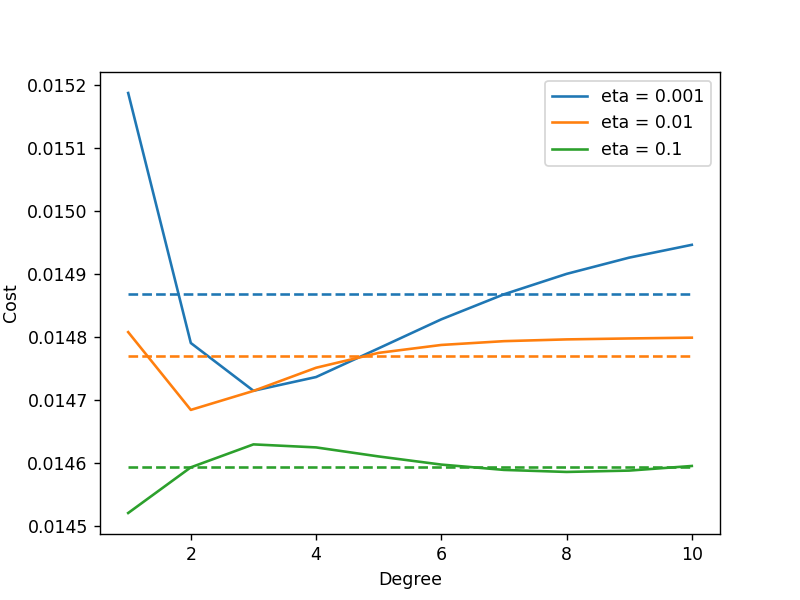

In [16]:
avg_cost = {}
plt.figure()
for eta in etas:
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(list(temp_val_cost_gd[eta].keys()), list(temp_val_cost_gd[eta].values()), color = color, label = f'eta = {eta}')
    avg_cost[eta] = np.mean(list(temp_val_cost_gd[eta].values()))
    plt.plot(np.arange(1, max_degree + 1), [avg_cost[eta]] * max_degree, '--', color = color)
plt.xlabel('Degree')
plt.ylabel('Cost')
plt.legend();

### Finding best learning rate

In [17]:
best_eta_gd = min(avg_cost, key = avg_cost.get)
print(f'Best learning rate with lowest average validation cost is {best_eta_gd}')

W_gd['nr'] = temp_W_gd[best_eta_gd]
train_cost_gd['nr'] = temp_train_cost_gd[best_eta_gd]
train_accuracy_gd['nr'] = temp_train_accuracy_gd[best_eta_gd]
val_cost_gd['nr'] = temp_val_cost_gd[best_eta_gd]
val_accuracy_gd['nr'] = temp_val_accuracy_gd[best_eta_gd]

Best learning rate with lowest average validation cost is 0.1


In [18]:
val_cost_gd['nr']

{1: 0.014520540127792825,
 2: 0.014593049414749287,
 3: 0.014629479675423093,
 4: 0.014624686746326832,
 5: 0.014610321685892647,
 6: 0.014597413688788315,
 7: 0.014588952486884252,
 8: 0.0145857291103933,
 9: 0.01458787023816585,
 10: 0.014595199216954272}

### Generating Surface Plots for different degrees

<IPython.core.display.Javascript object>


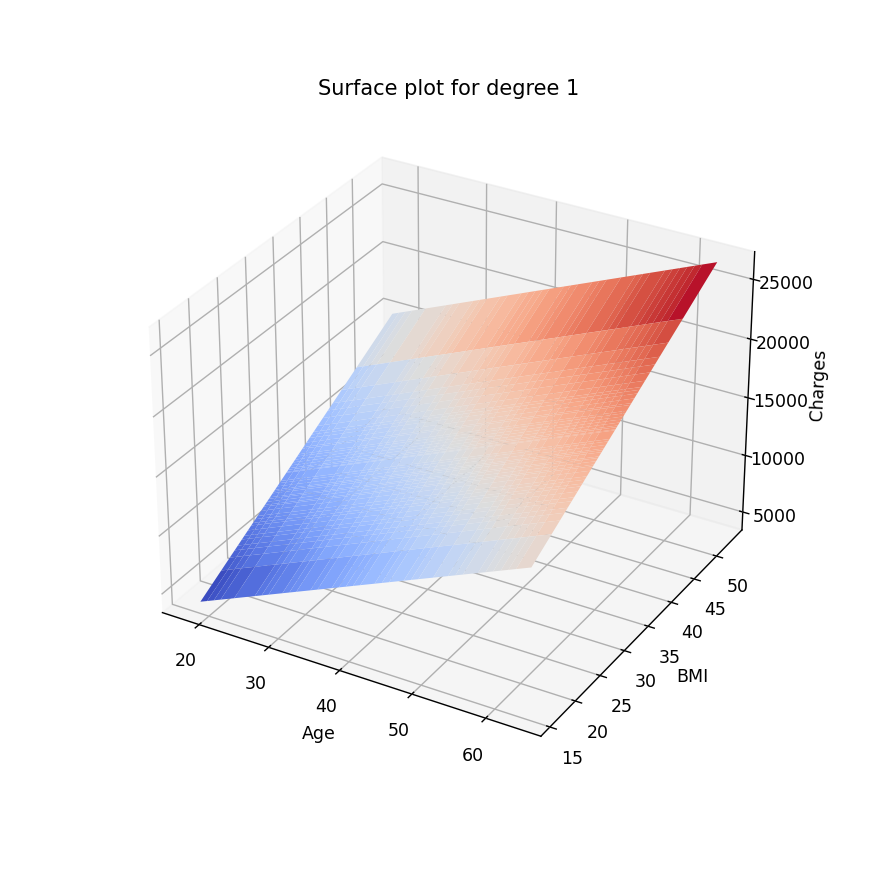

<IPython.core.display.Javascript object>


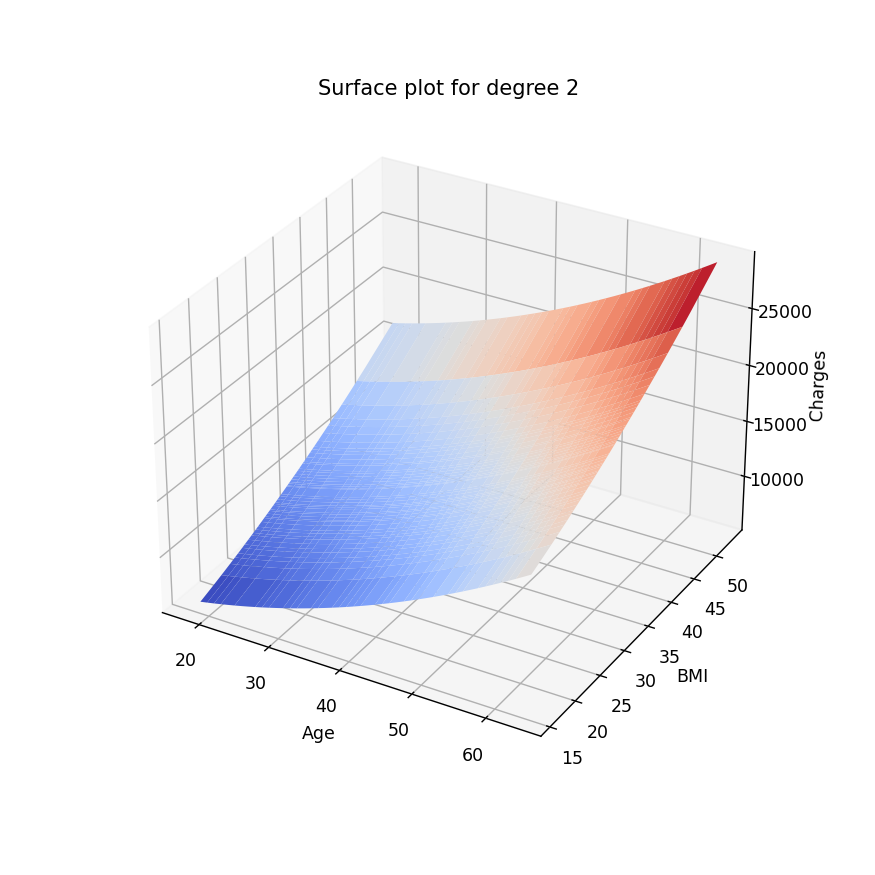

<IPython.core.display.Javascript object>


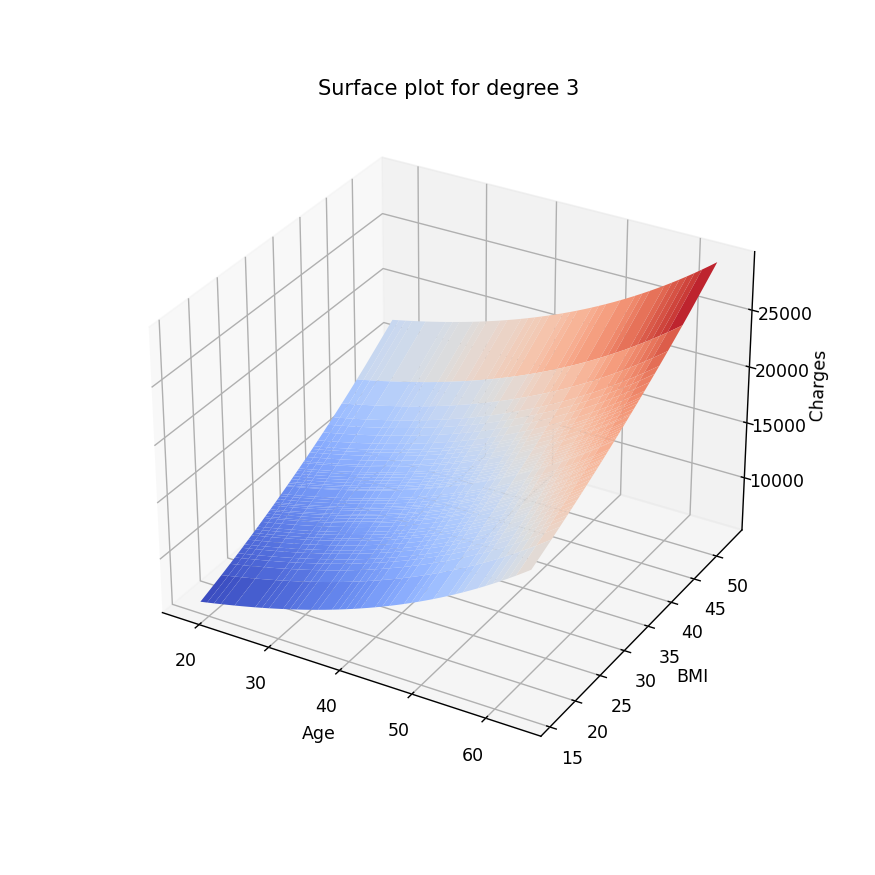

<IPython.core.display.Javascript object>


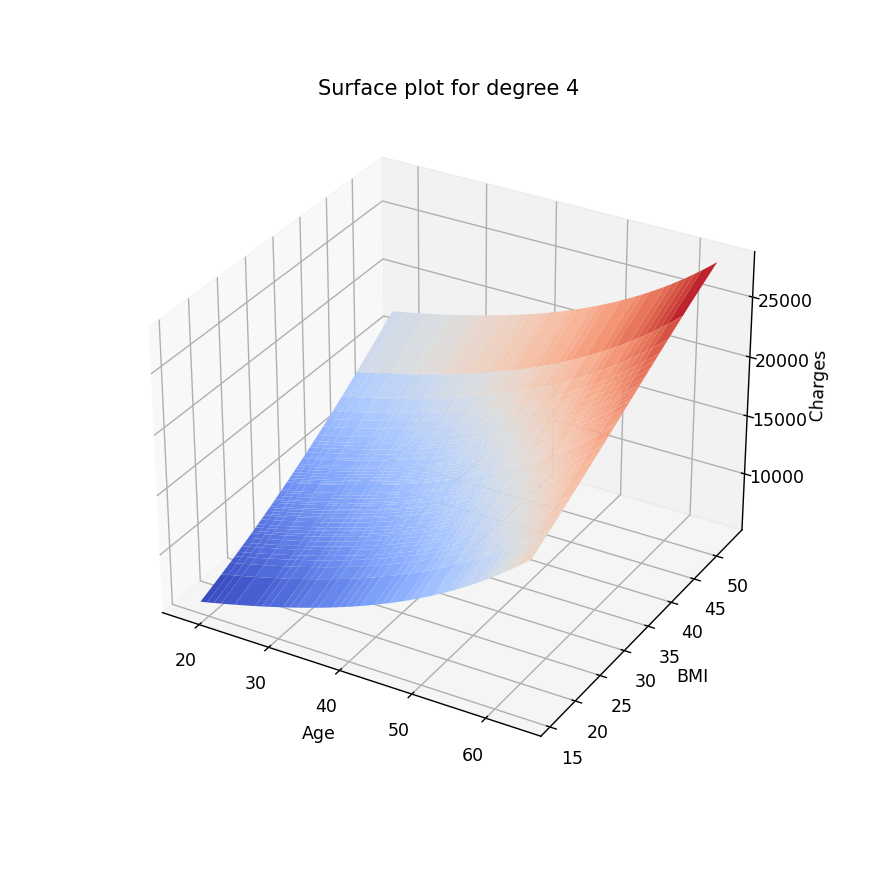

<IPython.core.display.Javascript object>


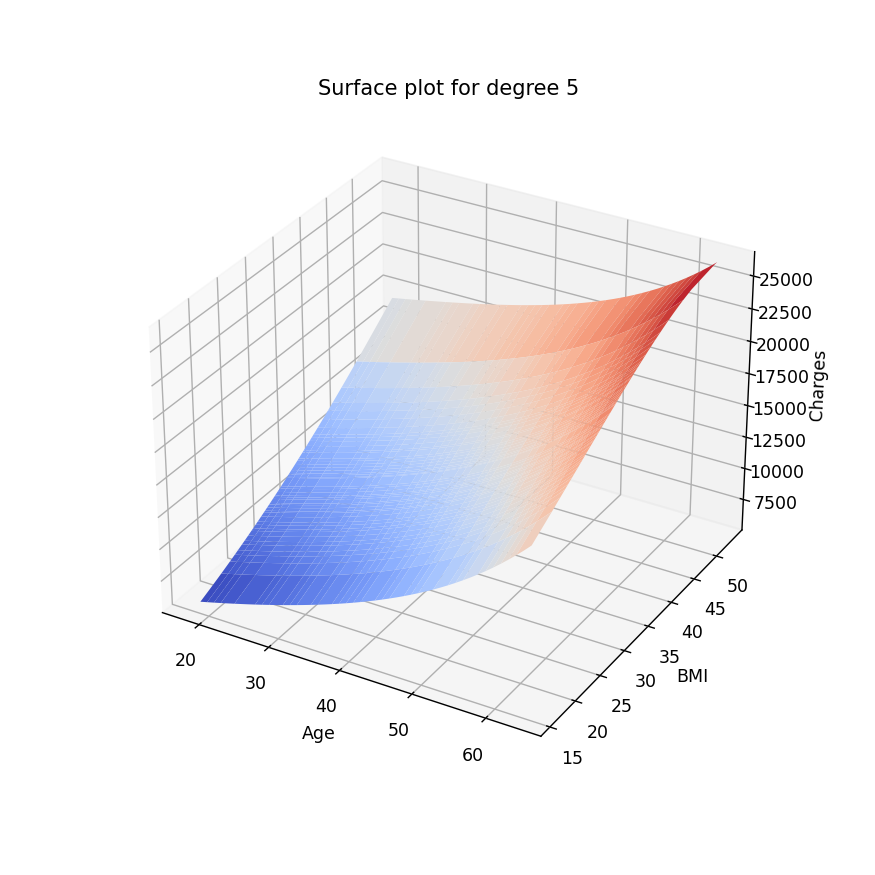

<IPython.core.display.Javascript object>


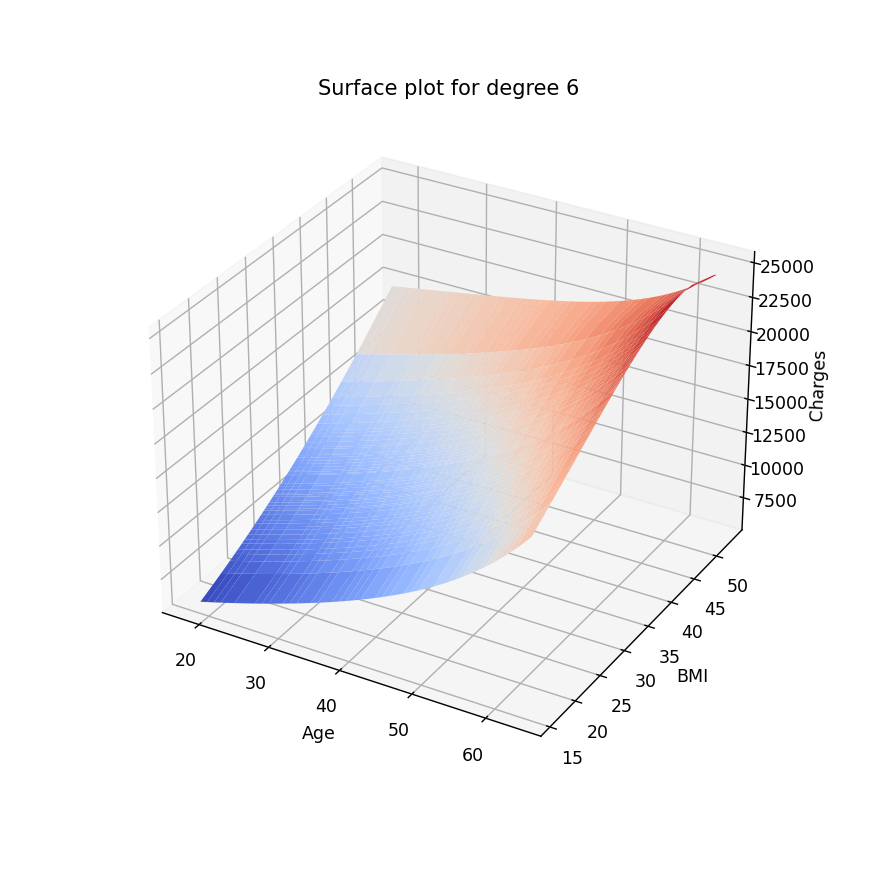

<IPython.core.display.Javascript object>


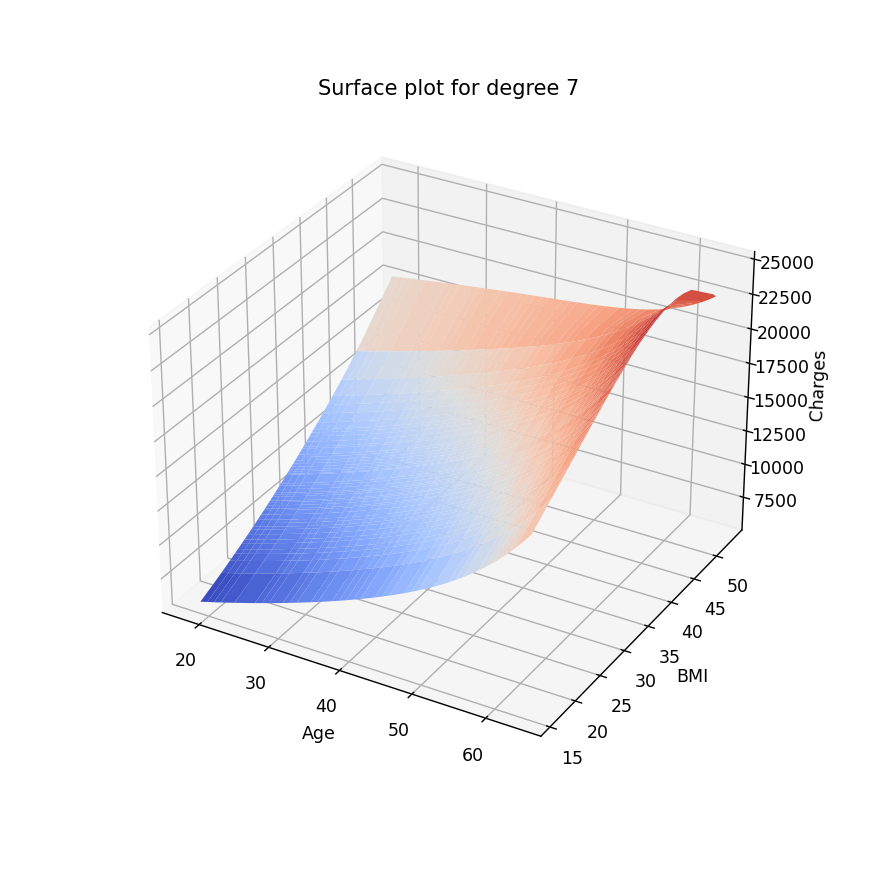

<IPython.core.display.Javascript object>


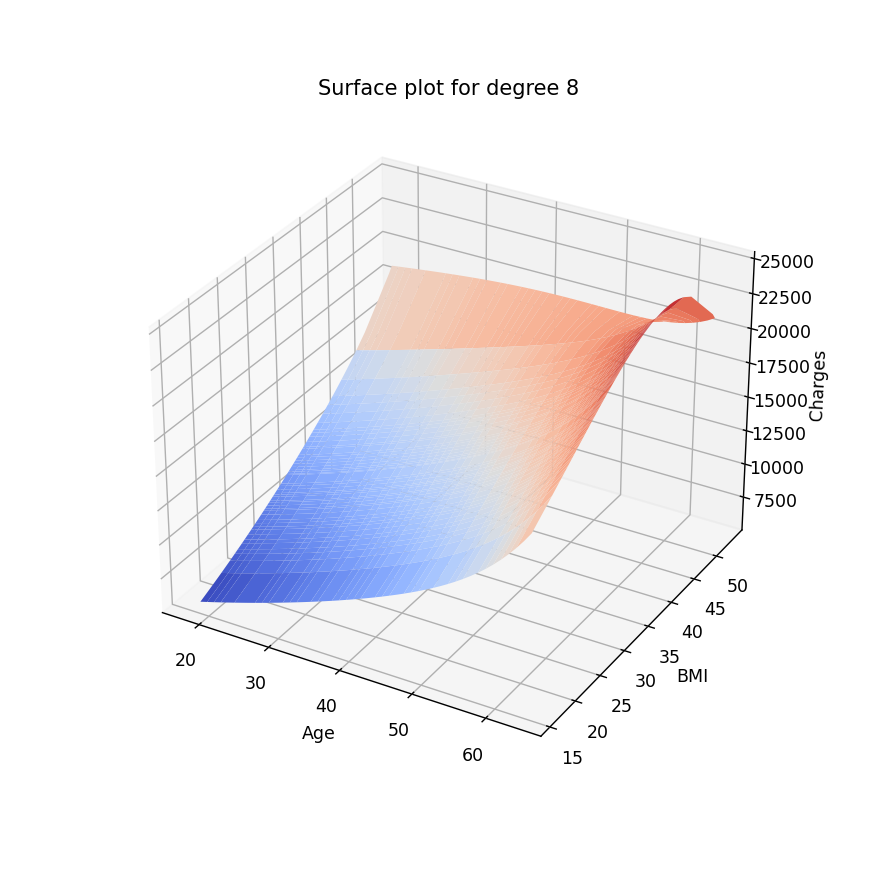

<IPython.core.display.Javascript object>


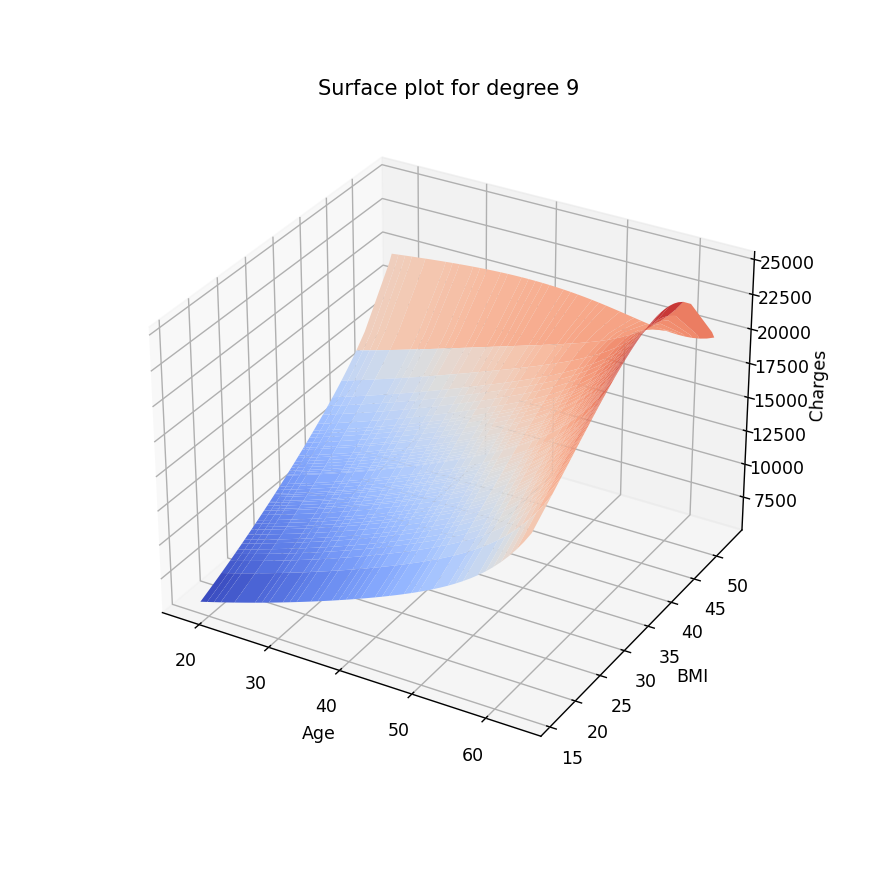

<IPython.core.display.Javascript object>


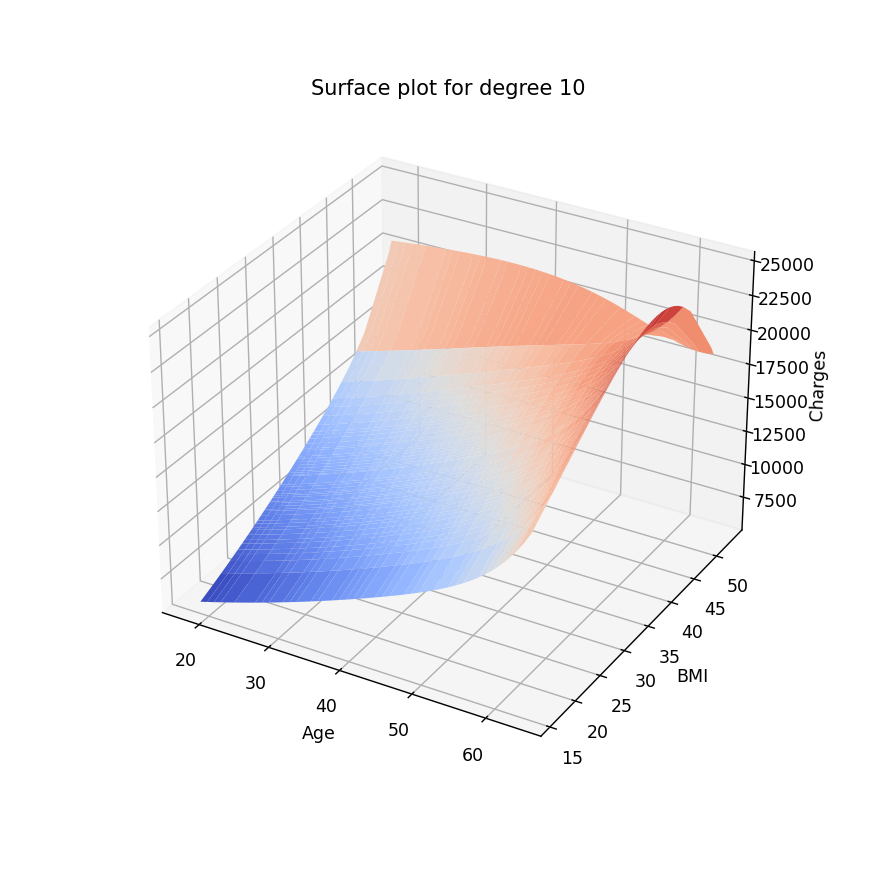

In [19]:
# Surface plot code

# _, _, _, _, X_test, _ = shuffle(df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')
X_test = df.drop(columns = 'charges', inplace = False).sample(frac = 0.2).to_numpy()

X_axis = X_test[:, 0]
Y_axis = X_test[:, 1]
X_axis = np.sort(X_axis)
Y_axis = np.sort(Y_axis)
X_axis, Y_axis = np.meshgrid(X_axis, Y_axis)

for i in range(1, max_degree + 1):
    poly = PolynomialFeatures(i)
    Z = np.zeros(X_axis.shape)
    
    for j in range(X_axis.shape[0]):
        for k in range(X_axis.shape[1]):
            X_normalized = normalize(X_axis[j, k], name = 'age')
            Y_normalized = normalize(Y_axis[j, k], name = 'bmi')
            arr = np.array([X_normalized, Y_normalized]).reshape(-1, 2)
            poly_features = poly.fit_transform(arr)
            pred = predict(W_gd['nr'][i], poly_features).flatten()[0]
            pred_denormalized = denormalize(pred, name = 'charges')
            Z[j, k] = pred_denormalized
    
#     a = np.vstack((X_axis, Y_axis, Z)).T
#     a = a[np.lexsort((a[:,0], a[:,1]))]
#     n = a.T.shape[0]
#     xs = a.T[:(n//3), :]
#     ys = a.T[(n//3):2*(n//3), :]
#     zs = a.T[2*(n//3):n, :]
    
    plt.figure(figsize = (7, 7))
    ax = plt.axes(projection = '3d')
    ax.plot_surface(X_axis, Y_axis, Z, cmap = 'coolwarm')
#     ax.plot_surface(xs, ys, zs, cmap = 'coolwarm')
    ax.set_xlabel('Age')
    ax.set_ylabel('BMI')
    ax.set_zlabel('Charges')
    ax.set_title(f'Surface plot for degree {i}')

### Running with Lasso Regularization for various $ \lambda $

In [20]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_gd[i] = {}
    temp_train_cost_gd[i] = {}
    temp_train_accuracy_gd[i] = {}
    temp_val_cost_gd[i] = {}
    temp_val_accuracy_gd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda1 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda1}')
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[i][lambda1], temp_train_cost_gd[i][lambda1], temp_train_accuracy_gd[i][lambda1] = \
                                                gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda1 = lambda1)
        
        predictions = predict(temp_W_gd[i][lambda1], X_val_poly)
        temp_val_cost_gd[i][lambda1] = calculate_cost(Y_val, predictions, temp_W_gd[i][lambda1], lambda1 = lambda1)
        temp_val_accuracy_gd[i][lambda1] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[i][lambda1]}, Validation Accuracy = {temp_val_accuracy_gd[i][lambda1]}')
        print()

Training 1-degree model with lambda = 0.9569504151050933
Cost after 1 iterations is 0.031312482336193145, accuracy = -0.7422623743691792
Cost after 400 iterations is 0.016339881922443487, accuracy = 0.10005538669870429
Cost after 800 iterations is 0.016318430818222943, accuracy = 0.10173362434250133
Cost after 1200 iterations is 0.016315248662780783, accuracy = 0.10208428774601963
Cost after 1600 iterations is 0.01631475496132873, accuracy = 0.10217934440358489
Cost after 2000 iterations is 0.016314678317255256, accuracy = 0.10221019851084534

Validation Cost = 0.017617262022344565, Validation Accuracy = 0.12454958747065592

Training 1-degree model with lambda = 0.31781177911863334
Cost after 1 iterations is 0.03129957183863384, accuracy = -0.7422623743691792
Cost after 400 iterations is 0.016215831312919916, accuracy = 0.10046223946291089
Cost after 800 iterations is 0.016191380724123898, accuracy = 0.10199461207330907
Cost after 1200 iterations is 0.016187737338392554, accuracy = 0.1

Cost after 400 iterations is 0.016296037622799693, accuracy = 0.10299730508369487
Cost after 800 iterations is 0.01628881085881438, accuracy = 0.10348598833645306
Cost after 1200 iterations is 0.01628368140256919, accuracy = 0.10370709200888484
Cost after 1600 iterations is 0.016279113653746475, accuracy = 0.10387406077083372
Cost after 2000 iterations is 0.016274986418662266, accuracy = 0.10401530421935523

Validation Cost = 0.01761803198346049, Validation Accuracy = 0.1231974490533102

Training 2-degree model with lambda = 0.11059057123348093
Cost after 1 iterations is 0.030492173798386316, accuracy = -0.6974905855763223
Cost after 400 iterations is 0.016130471682334863, accuracy = 0.10327685651555996
Cost after 800 iterations is 0.016125002708876335, accuracy = 0.10360177709877394
Cost after 1200 iterations is 0.01612209610030108, accuracy = 0.10376085363179721
Cost after 1600 iterations is 0.016119618622282075, accuracy = 0.10389226490249681
Cost after 2000 iterations is 0.01611743

Cost after 400 iterations is 0.016176453433833067, accuracy = 0.10331499690737822
Cost after 800 iterations is 0.016165513584034955, accuracy = 0.10384663878994949
Cost after 1200 iterations is 0.01616040020065035, accuracy = 0.10410654389915419
Cost after 1600 iterations is 0.016157358661415953, accuracy = 0.10424795269238729
Cost after 2000 iterations is 0.016154700954452626, accuracy = 0.10436593324763244

Validation Cost = 0.017221005104952915, Validation Accuracy = 0.12311974840330608

Training 3-degree model with lambda = 0.27758897930779136
Cost after 1 iterations is 0.030031847048251754, accuracy = -0.6714834226218758
Cost after 400 iterations is 0.016169714632632698, accuracy = 0.10331576518164831
Cost after 800 iterations is 0.016159110649968545, accuracy = 0.10383853983803604
Cost after 1200 iterations is 0.016153862101470302, accuracy = 0.10410592792008355
Cost after 1600 iterations is 0.016150882778950534, accuracy = 0.10425788883624354
Cost after 2000 iterations is 0.0161

Cost after 400 iterations is 0.016117255007891563, accuracy = 0.10325561858502463
Cost after 800 iterations is 0.016103889501386366, accuracy = 0.10400503934544403
Cost after 1200 iterations is 0.016094677081594625, accuracy = 0.10453474963340448
Cost after 1600 iterations is 0.016088397841284005, accuracy = 0.10491581454051768
Cost after 2000 iterations is 0.01608377918421299, accuracy = 0.10520405457132287

Validation Cost = 0.01701407612883148, Validation Accuracy = 0.12371863742278966

Training 5-degree model with lambda = 0.10949665721202306
Cost after 1 iterations is 0.029515716710469302, accuracy = -0.6430145444086244
Cost after 400 iterations is 0.016131259021376763, accuracy = 0.10336082745041786
Cost after 800 iterations is 0.01611616134466013, accuracy = 0.10424457014162669
Cost after 1200 iterations is 0.016107023713992717, accuracy = 0.10479842706001108
Cost after 1600 iterations is 0.01610169697421632, accuracy = 0.10515737207233455
Cost after 2000 iterations is 0.0160980

Cost after 800 iterations is 0.0161663655126082, accuracy = 0.10413858608168025
Cost after 1200 iterations is 0.01616002513042662, accuracy = 0.10450614882157305
Cost after 1600 iterations is 0.016156247836894014, accuracy = 0.10475286167141618
Cost after 2000 iterations is 0.01615309321144314, accuracy = 0.10494854822975408

Validation Cost = 0.017252126022341392, Validation Accuracy = 0.12311172440697549

Training 6-degree model with lambda = 0.6821465887724861
Cost after 1 iterations is 0.02939073528084436, accuracy = -0.634374704949989
Cost after 400 iterations is 0.016259364720250143, accuracy = 0.1033886821311123
Cost after 800 iterations is 0.016243589580501174, accuracy = 0.104101442855973
Cost after 1200 iterations is 0.016237736478445893, accuracy = 0.10436788313879808
Cost after 1600 iterations is 0.016233208274787806, accuracy = 0.10454500718149828
Cost after 2000 iterations is 0.016229689182709207, accuracy = 0.10468816235065037

Validation Cost = 0.017511999862355163, Val

Cost after 800 iterations is 0.016132701979459096, accuracy = 0.10434704329274591
Cost after 1200 iterations is 0.016124236065883823, accuracy = 0.10486249649789436
Cost after 1600 iterations is 0.016119770006422125, accuracy = 0.10518324075427454
Cost after 2000 iterations is 0.016116484582059484, accuracy = 0.1054183504631464

Validation Cost = 0.01714540615923742, Validation Accuracy = 0.12353658287874747

Training 7-degree model with lambda = 0.31259185043666127
Cost after 1 iterations is 0.029253040956835643, accuracy = -0.6277048903750195
Cost after 400 iterations is 0.01617640622062207, accuracy = 0.1034657063451887
Cost after 800 iterations is 0.016161946299724478, accuracy = 0.10420429097957629
Cost after 1200 iterations is 0.016155181963691225, accuracy = 0.10460505530763753
Cost after 1600 iterations is 0.01615118586726696, accuracy = 0.10487272770979017
Cost after 2000 iterations is 0.016147871788375383, accuracy = 0.1050847756238914

Validation Cost = 0.017241954857386735,

Cost after 800 iterations is 0.016199349614950752, accuracy = 0.10421964290797336
Cost after 1200 iterations is 0.016193431021319742, accuracy = 0.10453515541446234
Cost after 1600 iterations is 0.016189008721330195, accuracy = 0.10473398983437321
Cost after 2000 iterations is 0.01618542668196884, accuracy = 0.10490034823711414

Validation Cost = 0.017366956468068524, Validation Accuracy = 0.1228633332204635

Training 8-degree model with lambda = 0.39739591052780243
Cost after 1 iterations is 0.029163526944048515, accuracy = -0.6223766165264035
Cost after 400 iterations is 0.016195134796951827, accuracy = 0.10350110678623092
Cost after 800 iterations is 0.016179955722641238, accuracy = 0.10422386530921901
Cost after 1200 iterations is 0.016173773190598418, accuracy = 0.10456082691901947
Cost after 1600 iterations is 0.01616956778965275, accuracy = 0.10478928962401302
Cost after 2000 iterations is 0.016165978529753974, accuracy = 0.10497528784139498

Validation Cost = 0.0173020115259173

Cost after 1200 iterations is 0.016292883860797285, accuracy = 0.1044724539731231
Cost after 1600 iterations is 0.016287541619010467, accuracy = 0.1047046063987771
Cost after 2000 iterations is 0.016282845333958025, accuracy = 0.1048879107600953

Validation Cost = 0.017717730949652618, Validation Accuracy = 0.12229776652192414

Training 10-degree model with lambda = 0.6159565816120356
Cost after 1 iterations is 0.029035922844798112, accuracy = -0.6143311005330601
Cost after 400 iterations is 0.016243506003796405, accuracy = 0.10351389585383175
Cost after 800 iterations is 0.016227313820110355, accuracy = 0.10428466696859384
Cost after 1200 iterations is 0.01622090243213682, accuracy = 0.1046271017989655
Cost after 1600 iterations is 0.016215761439694314, accuracy = 0.10485300138361386
Cost after 2000 iterations is 0.01621196665306652, accuracy = 0.10503383738291605

Validation Cost = 0.01747083155206634, Validation Accuracy = 0.1227238504027951

Training 10-degree model with lambda = 0

### Finding best $ \lambda $ for different degrees

In [21]:
best_lambda1_gd = {i: min(temp_val_cost_gd[i], key = temp_val_cost_gd[i].get) for i in range(1, max_degree + 1)}
best_lambda1_gd

{1: 0.02910639252002367,
 2: 0.11059057123348093,
 3: 0.13491497736281066,
 4: 0.008702433279120236,
 5: 0.10949665721202306,
 6: 0.32902587678842,
 7: 0.07776776288159049,
 8: 0.06417858910380636,
 9: 0.029246577763218484,
 10: 0.0322162571903154}

In [22]:
W_gd['r1'] = {i: {'W':temp_W_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
train_cost_gd['r1'] = {i: {'cost':temp_train_cost_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
train_accuracy_gd['r1'] = {i: {'cost':temp_train_accuracy_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
val_cost_gd['r1'] = {i: {'cost':temp_val_cost_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}
val_accuracy_gd['r1'] = {i: {'cost':temp_val_accuracy_gd[i][best_lambda1_gd[i]], 'lambda': best_lambda1_gd[i]} for i in range(1, max_degree + 1)}

In [23]:
val_cost_gd['r1']

{1: {'cost': 0.01694998927516972, 'lambda': 0.02910639252002367},
 2: {'cost': 0.01704497183329392, 'lambda': 0.11059057123348093},
 3: {'cost': 0.017091261416131327, 'lambda': 0.13491497736281066},
 4: {'cost': 0.016978513888863393, 'lambda': 0.008702433279120236},
 5: {'cost': 0.017073002422490657, 'lambda': 0.10949665721202306},
 6: {'cost': 0.017252126022341392, 'lambda': 0.32902587678842},
 7: {'cost': 0.01703428083962069, 'lambda': 0.07776776288159049},
 8: {'cost': 0.01701546343783135, 'lambda': 0.06417858910380636},
 9: {'cost': 0.01696155630282025, 'lambda': 0.029246577763218484},
 10: {'cost': 0.01696765111658316, 'lambda': 0.0322162571903154}}

### Running with Ridge Regularization for various $ \lambda $

In [24]:
temp_W_gd = {}
temp_train_cost_gd = {}
temp_train_accuracy_gd = {}
temp_val_cost_gd = {}
temp_val_accuracy_gd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_gd[i] = {}
    temp_train_cost_gd[i] = {}
    temp_train_accuracy_gd[i] = {}
    temp_val_cost_gd[i] = {}
    temp_val_accuracy_gd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda2 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda2}')
        
        W = initialize_weights(X_train_poly)
        temp_W_gd[i][lambda2], temp_train_cost_gd[i][lambda2], temp_train_accuracy_gd[i][lambda2] = \
                                                gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda2 = lambda2)
        
        predictions = predict(temp_W_gd[i][lambda2], X_val_poly)
        temp_val_cost_gd[i][lambda2] = calculate_cost(Y_val, predictions, temp_W_gd[i][lambda2], lambda2 = lambda2)
        temp_val_accuracy_gd[i][lambda2] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_gd[i][lambda2]}, Validation Accuracy = {temp_val_accuracy_gd[i][lambda2]}')
        print()

Training 1-degree model with lambda = 0.512062286723919
Cost after 1 iterations is 0.033129401383873956, accuracy = -0.7675193200607733
Cost after 400 iterations is 0.016801705176430017, accuracy = 0.10432681655301868
Cost after 800 iterations is 0.016761336602236505, accuracy = 0.10662595523609608
Cost after 1200 iterations is 0.01675529612164477, accuracy = 0.1070119531831546
Cost after 1600 iterations is 0.016754372361218083, accuracy = 0.1070877273372215
Cost after 2000 iterations is 0.01675423105084892, accuracy = 0.10710589064245979

Validation Cost = 0.016929853320170603, Validation Accuracy = 0.13450393283612982

Training 1-degree model with lambda = 0.34760980013420917
Cost after 1 iterations is 0.03312934996143877, accuracy = -0.7675193200607733
Cost after 400 iterations is 0.01679676633796562, accuracy = 0.10435515907789694
Cost after 800 iterations is 0.01675562474504267, accuracy = 0.10665022403073066
Cost after 1200 iterations is 0.01674938098515493, accuracy = 0.10702758

Cost after 1 iterations is 0.032290467792688446, accuracy = -0.7227581123706364
Cost after 400 iterations is 0.016785711604925955, accuracy = 0.10497540206914358
Cost after 800 iterations is 0.016776239412429735, accuracy = 0.10551873361547959
Cost after 1200 iterations is 0.016771688159319578, accuracy = 0.10578206048597705
Cost after 1600 iterations is 0.01676792458117041, accuracy = 0.10600286767229472
Cost after 2000 iterations is 0.016764725382252033, accuracy = 0.1061955277761697

Validation Cost = 0.016832344082048683, Validation Accuracy = 0.1383292671871531

Training 2-degree model with lambda = 0.974490729686721
Cost after 1 iterations is 0.03229062147531811, accuracy = -0.7227581123706364
Cost after 400 iterations is 0.016793607023309065, accuracy = 0.10495605549732001
Cost after 800 iterations is 0.016784594283595647, accuracy = 0.10550151406087072
Cost after 1200 iterations is 0.016780431335817, accuracy = 0.10575752934459193
Cost after 1600 iterations is 0.016777111259291

Cost after 800 iterations is 0.016784646007062025, accuracy = 0.10492725583670082
Cost after 1200 iterations is 0.016769837140938944, accuracy = 0.10576572566783993
Cost after 1600 iterations is 0.016758937192721472, accuracy = 0.1064002190593466
Cost after 2000 iterations is 0.016750732966568493, accuracy = 0.10689249800295375

Validation Cost = 0.016829698289435084, Validation Accuracy = 0.13829838760221358

Training 3-degree model with lambda = 0.5595114231042374
Cost after 1 iterations is 0.03181426884179902, accuracy = -0.6973508026630646
Cost after 400 iterations is 0.016807625854492952, accuracy = 0.10373822081706996
Cost after 800 iterations is 0.016786479909084318, accuracy = 0.10491795907880896
Cost after 1200 iterations is 0.016771971167072294, accuracy = 0.10574967659409307
Cost after 1600 iterations is 0.01676138037025536, accuracy = 0.1063774402594686
Cost after 2000 iterations is 0.016753474675387597, accuracy = 0.10686347784682815

Validation Cost = 0.016836592132885752

Cost after 1200 iterations is 0.016729931189644356, accuracy = 0.10800130325217439
Cost after 1600 iterations is 0.016713657106190313, accuracy = 0.1089649237183885
Cost after 2000 iterations is 0.01670312709739151, accuracy = 0.10961350138104253

Validation Cost = 0.016838056295796763, Validation Accuracy = 0.1384785808626703

Training 5-degree model with lambda = 0.9815085625405842
Cost after 1 iterations is 0.03130715882061905, accuracy = -0.6702847210125962
Cost after 400 iterations is 0.016811994817281906, accuracy = 0.10384092186124017
Cost after 800 iterations is 0.0167678337652735, accuracy = 0.10638893970597674
Cost after 1200 iterations is 0.016744121652362064, accuracy = 0.10784809338896229
Cost after 1600 iterations is 0.016730131278399986, accuracy = 0.10877319103416716
Cost after 2000 iterations is 0.016721467137160762, accuracy = 0.10939327378053254

Validation Cost = 0.016882397657276938, Validation Accuracy = 0.1387530489709563

Training 5-degree model with lambda = 0.

Cost after 1600 iterations is 0.016680769350389965, accuracy = 0.11016065564425703
Cost after 2000 iterations is 0.016669113176343474, accuracy = 0.11079818810812203

Validation Cost = 0.01679592541755737, Validation Accuracy = 0.13852187892965728

Training 6-degree model with lambda = 0.340200722877398
Cost after 1 iterations is 0.031156406432992934, accuracy = -0.6622562055235823
Cost after 400 iterations is 0.01679048992521834, accuracy = 0.10447432422375846
Cost after 800 iterations is 0.016736244384142573, accuracy = 0.10745070788506272
Cost after 1200 iterations is 0.016707310994437237, accuracy = 0.10907672951872882
Cost after 1600 iterations is 0.016690314278475553, accuracy = 0.11005909641325151
Cost after 2000 iterations is 0.016679781250522156, accuracy = 0.11068763750771315

Validation Cost = 0.016822909262721057, Validation Accuracy = 0.13867942503541708

Training 6-degree model with lambda = 0.5549855025749343
Cost after 1 iterations is 0.031156500529427124, accuracy = -0

Cost after 2000 iterations is 0.016658198410095172, accuracy = 0.11153266654192484

Validation Cost = 0.01679963159636628, Validation Accuracy = 0.13884336047497126

Training 7-degree model with lambda = 0.3722820119446375
Cost after 1 iterations is 0.03104149400272462, accuracy = -0.6561244650427809
Cost after 400 iterations is 0.016780399318549705, accuracy = 0.10504608633720036
Cost after 800 iterations is 0.016722351943264376, accuracy = 0.1082411073439713
Cost after 1200 iterations is 0.016692963298329925, accuracy = 0.10990385984848661
Cost after 1600 iterations is 0.01667663590803801, accuracy = 0.11085883177700828
Cost after 2000 iterations is 0.016666963629854894, accuracy = 0.11144615392334134

Validation Cost = 0.01682214606069607, Validation Accuracy = 0.13896969235655443

Training 7-degree model with lambda = 0.21906868620753273
Cost after 1 iterations is 0.031041425686692558, accuracy = -0.6561244650427809
Cost after 400 iterations is 0.016777614083005887, accuracy = 0.10

Cost after 400 iterations is 0.01676034483592482, accuracy = 0.10602510306536406
Cost after 800 iterations is 0.016696687638000356, accuracy = 0.10949708317455709
Cost after 1200 iterations is 0.016666904818150516, accuracy = 0.1111562876150487
Cost after 1600 iterations is 0.016651648259211588, accuracy = 0.11202907899631886
Cost after 2000 iterations is 0.016643082016230024, accuracy = 0.11253355575094748

Validation Cost = 0.016800323739730807, Validation Accuracy = 0.1394615799620763

Training 9-degree model with lambda = 0.1932415797044279
Cost after 1 iterations is 0.030876423511542208, accuracy = -0.6473217259925241
Cost after 400 iterations is 0.016759124878823244, accuracy = 0.10603356018599241
Cost after 800 iterations is 0.016694964129084743, accuracy = 0.10951382366438545
Cost after 1200 iterations is 0.01666477871511028, accuracy = 0.11117747550794277
Cost after 1600 iterations is 0.016649230078445033, accuracy = 0.11205174872239321
Cost after 2000 iterations is 0.01664045

Cost after 800 iterations is 0.016690557667109873, accuracy = 0.10994537839834428
Cost after 1200 iterations is 0.016661971074383594, accuracy = 0.11156710689878113
Cost after 1600 iterations is 0.01664804427359602, accuracy = 0.11238824933787539
Cost after 2000 iterations is 0.01664051223444837, accuracy = 0.11285108959460399

Validation Cost = 0.01680546225854538, Validation Accuracy = 0.13980465779626217

Training 10-degree model with lambda = 0.44182642722550003
Cost after 1 iterations is 0.03081491991888631, accuracy = -0.6440342048615706
Cost after 400 iterations is 0.016756567236326424, accuracy = 0.1063924346411379
Cost after 800 iterations is 0.016692870617020857, accuracy = 0.10992268684197215
Cost after 1200 iterations is 0.01666478977513407, accuracy = 0.11153915042124973
Cost after 1600 iterations is 0.016651209960929916, accuracy = 0.11235888369048097
Cost after 2000 iterations is 0.016643919656013605, accuracy = 0.11282182309152167

Validation Cost = 0.016814531767106896

### Finding best $ \lambda $ for different degrees

In [25]:
best_lambda2_gd = {i: min(temp_val_cost_gd[i], key = temp_val_cost_gd[i].get) for i in range(1, max_degree + 1)}
best_lambda2_gd

{1: 0.16141094315921056,
 2: 0.06018094083935677,
 3: 0.013413745151899081,
 4: 0.07946854352355492,
 5: 0.06809418221905927,
 6: 0.02494350625279751,
 7: 0.15598243092866415,
 8: 0.03499111333523519,
 9: 0.025000515794799116,
 10: 0.10661152587779177}

In [26]:
W_gd['r2'] = {i: {'W':temp_W_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
train_cost_gd['r2'] = {i: {'cost':temp_train_cost_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
train_accuracy_gd['r2'] = {i: {'cost':temp_train_accuracy_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
val_cost_gd['r2'] = {i: {'cost':temp_val_cost_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}
val_accuracy_gd['r2'] = {i: {'cost':temp_val_accuracy_gd[i][best_lambda2_gd[i]], 'lambda': best_lambda2_gd[i]} for i in range(1, max_degree + 1)}

In [27]:
val_cost_gd['r2']

{1: {'cost': 0.016884917076748152, 'lambda': 0.16141094315921056},
 2: {'cost': 0.01679710510300011, 'lambda': 0.06018094083935677},
 3: {'cost': 0.016796555351761375, 'lambda': 0.013413745151899081},
 4: {'cost': 0.01680445365038163, 'lambda': 0.07946854352355492},
 5: {'cost': 0.016800157426803585, 'lambda': 0.06809418221905927},
 6: {'cost': 0.016790744485922694, 'lambda': 0.02494350625279751},
 7: {'cost': 0.01679963159636628, 'lambda': 0.15598243092866415},
 8: {'cost': 0.016781324244463647, 'lambda': 0.03499111333523519},
 9: {'cost': 0.016774700778445305, 'lambda': 0.025000515794799116},
 10: {'cost': 0.01677826208969176, 'lambda': 0.10661152587779177}}

# Building Stochastic Gradient Descent model
## Function for finding W using Stochastic Gradient Descent

In [28]:
def stochastic_gradient_descent(X, Y, W, eta = 0.1, lambda1 = 0, lambda2 = 0, num_iterations = 10000):
    print_space = num_iterations // 5 if num_iterations > 5 else 1
    m = len(X)
    J = {}
    accuracy = {}
    for i in range(1, num_iterations + 1):
        j = np.random.choice(m, replace=False)
        x = np.array(X[j]).reshape((1, len(W)))
        y = np.array(Y[j]).reshape((1, 1))
        dReg1 = lambda1 / (2 * m) * np.sign(W)
        dReg2 = (lambda2 / m) * W
        dW_old = (1 / m) * (x.T @ (x @ W - y))
        dW = dW_old + dReg1 + dReg2
        W = W - (eta * dW)
        prediction = predict(W, X)
        cost = calculate_cost(Y, prediction, W, lambda1, lambda2)
        J[i] = cost
        acc = calculate_accuracy(Y, prediction)
        accuracy[i] = acc
        if i == 1 or i % print_space == 0:
            print(f'Cost after {i} iterations is {cost}, accuracy = {acc}')
    return W, J, accuracy

## Applying Stochastic Gradient Descent

In [29]:
# Initializing important variables
W_sgd = {}
train_cost_sgd = {}
train_accuracy_sgd = {}
val_cost_sgd = {}
val_accuracy_sgd = {}

### Running without regularization for various learning rates

In [30]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

etas = [0.001, 0.01, 0.1]
max_degree = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for eta in etas:
    temp_W_sgd[eta] = {}
    temp_train_cost_sgd[eta] = {}
    temp_train_accuracy_sgd[eta] = {}
    temp_val_cost_sgd[eta] = {}
    temp_val_accuracy_sgd[eta] = {}

    for i in range(1, max_degree + 1):
        print(f'Training {i}-degree model with learning rate = {eta}')
        
        poly = PolynomialFeatures(i)
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[eta][i], temp_train_cost_sgd[eta][i], temp_train_accuracy_sgd[eta][i] = \
                                                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta)
        predictions = predict(temp_W_sgd[eta][i], X_val_poly)
        temp_val_cost_sgd[eta][i] = calculate_cost(Y_val, predictions, temp_W_sgd[eta][i])
        temp_val_accuracy_sgd[eta][i] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[eta][i]}, Validation Accuracy = {temp_val_accuracy_sgd[eta][i]}')
        print()

Training 1-degree model with learning rate = 0.001
Cost after 1 iterations is 0.03646602905508562, accuracy = -0.9912974109756822
Cost after 2000 iterations is 0.0363494387623964, accuracy = -0.9849307745748219
Cost after 4000 iterations is 0.036237716930999905, accuracy = -0.9788299898342285
Cost after 6000 iterations is 0.036124354964698374, accuracy = -0.9726396423834998
Cost after 8000 iterations is 0.036010353951124535, accuracy = -0.9664143985316049
Cost after 10000 iterations is 0.03590378933254095, accuracy = -0.9605952332814882

Validation Cost = 0.0408343266223381, Validation Accuracy = -0.997885677636819

Training 2-degree model with learning rate = 0.001
Cost after 1 iterations is 0.03646605995977812, accuracy = -0.9912990985856514
Cost after 2000 iterations is 0.03633013243514135, accuracy = -0.9838765155706304
Cost after 4000 iterations is 0.03619502416932081, accuracy = -0.9764986697535427
Cost after 6000 iterations is 0.0360622920186217, accuracy = -0.9692505762569599
C

Cost after 2000 iterations is 0.03498448214978168, accuracy = -0.9103947025312229
Cost after 4000 iterations is 0.03351355139940232, accuracy = -0.8300717095744004
Cost after 6000 iterations is 0.03221176416290886, accuracy = -0.7589851223906197
Cost after 8000 iterations is 0.03103667230367876, accuracy = -0.6948169791192822
Cost after 10000 iterations is 0.02994455364018973, accuracy = -0.6351797462360753

Validation Cost = 0.03462311980138852, Validation Accuracy = -0.6939923071599594

Training 5-degree model with learning rate = 0.01
Cost after 1 iterations is 0.03646534942721913, accuracy = -0.99126029859339
Cost after 2000 iterations is 0.034897399220468917, accuracy = -0.9056393722642853
Cost after 4000 iterations is 0.03347188556829385, accuracy = -0.8277964670058411
Cost after 6000 iterations is 0.03211590816917672, accuracy = -0.7537507221257329
Cost after 8000 iterations is 0.030899275045767605, accuracy = -0.6873141385017765
Cost after 10000 iterations is 0.0297978936470089

Cost after 4000 iterations is 0.020165186391935853, accuracy = -0.1011586535360327
Cost after 6000 iterations is 0.017994044328603725, accuracy = 0.01740072025930861
Cost after 8000 iterations is 0.017071984961499313, accuracy = 0.06775153931085065
Cost after 10000 iterations is 0.016612050301129805, accuracy = 0.09286715299689996

Validation Cost = 0.019710476320727473, Validation Accuracy = 0.035632968683779964

Training 8-degree model with learning rate = 0.1
Cost after 1 iterations is 0.03646561883060576, accuracy = -0.9912750098816827
Cost after 2000 iterations is 0.024840961629437275, accuracy = -0.35648832243625184
Cost after 4000 iterations is 0.020137274490668534, accuracy = -0.09963447066860098
Cost after 6000 iterations is 0.018075085488175255, accuracy = 0.01297531240934835
Cost after 8000 iterations is 0.017054676184846147, accuracy = 0.06869671823572177
Cost after 10000 iterations is 0.016676890767827544, accuracy = 0.0893264150331744

Validation Cost = 0.0198257169635194

### Visualizing the effect of learning rates

<IPython.core.display.Javascript object>


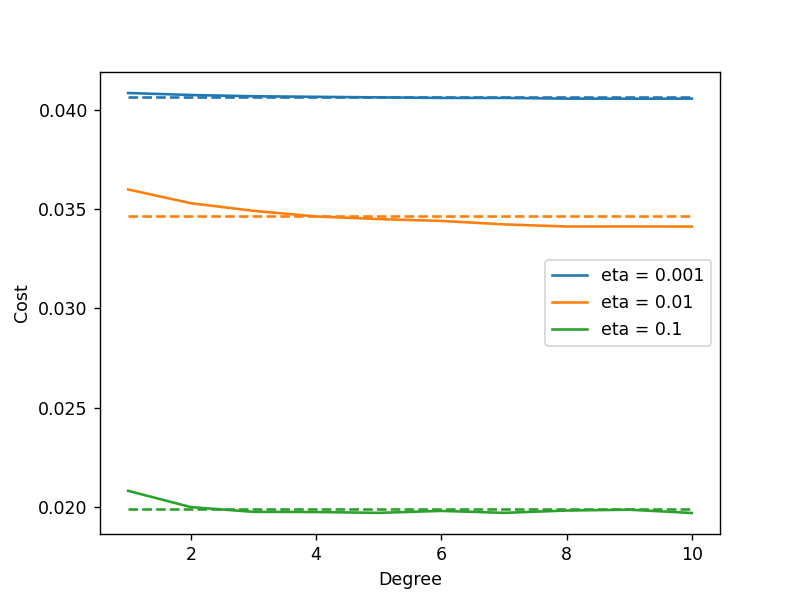

In [31]:
avg_cost = {}
plt.figure()
for eta in etas:
    color = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(list(temp_val_cost_sgd[eta].keys()), list(temp_val_cost_sgd[eta].values()), color = color, label = f'eta = {eta}')
    avg_cost[eta] = np.mean(list(temp_val_cost_sgd[eta].values()))
    plt.plot(np.arange(1, max_degree + 1), [avg_cost[eta]] * max_degree, '--', color = color)
plt.xlabel('Degree')
plt.ylabel('Cost')
plt.legend();

### Finding best learning rate

In [32]:
best_eta_sgd = min(avg_cost, key = avg_cost.get)
print(f'Best learning rate with lowest average validation cost is {best_eta_sgd}')

W_sgd['nr'] = temp_W_sgd[best_eta_sgd]
train_cost_sgd['nr'] = temp_train_cost_sgd[best_eta_sgd]
train_accuracy_sgd['nr'] = temp_train_accuracy_sgd[best_eta_sgd]
val_cost_sgd['nr'] = temp_val_cost_sgd[best_eta_sgd]
val_accuracy_sgd['nr'] = temp_val_accuracy_sgd[best_eta_sgd]

Best learning rate with lowest average validation cost is 0.1


In [33]:
val_cost_sgd['nr']

{1: 0.020818713635471085,
 2: 0.019999567204450265,
 3: 0.019759668347331494,
 4: 0.019752238033091934,
 5: 0.01971006490254519,
 6: 0.01980815791586004,
 7: 0.019710476320727473,
 8: 0.019825716963519403,
 9: 0.01986895384008774,
 10: 0.01970243519210855}

### Running with Lasso Regularization for various $ \lambda $

In [34]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_sgd[i] = {}
    temp_train_cost_sgd[i] = {}
    temp_train_accuracy_sgd[i] = {}
    temp_val_cost_sgd[i] = {}
    temp_val_accuracy_sgd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda1 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda1}')
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[i][lambda1], temp_train_cost_sgd[i][lambda1], temp_train_accuracy_sgd[i][lambda1] = \
                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda1 = lambda1)
        
        predictions = predict(temp_W_sgd[i][lambda1], X_val_poly)
        temp_val_cost_sgd[i][lambda1] = calculate_cost(Y_val, predictions, temp_W_sgd[i][lambda1], lambda1 = lambda1)
        temp_val_accuracy_sgd[i][lambda1] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[i][lambda1]}, Validation Accuracy = {temp_val_accuracy_sgd[i][lambda1]}')
        print()

Training 1-degree model with lambda = 0.36892653238341633
Cost after 1 iterations is 0.038621318237601066, accuracy = -0.988102460020932
Cost after 2000 iterations is 0.03811302404418418, accuracy = -0.9619103075558921
Cost after 4000 iterations is 0.03801429485405172, accuracy = -0.9568229576824088
Cost after 6000 iterations is 0.03789961893222263, accuracy = -0.9509135776876618
Cost after 8000 iterations is 0.037532446231212914, accuracy = -0.9319934270433574
Cost after 10000 iterations is 0.03733814151878436, accuracy = -0.9219806819240874

Validation Cost = 0.033282300528161016, Validation Accuracy = -1.0707439259870446

Training 1-degree model with lambda = 0.7958658024019207
Cost after 1 iterations is 0.03861644311908597, accuracy = -0.9878506892359595
Cost after 2000 iterations is 0.038625203908372006, accuracy = -0.9883010492018438
Cost after 4000 iterations is 0.03862353726304303, accuracy = -0.9882150365586222
Cost after 6000 iterations is 0.038616673077038595, accuracy = -0.

Cost after 2000 iterations is 0.028064183873141208, accuracy = -0.44465147974502806
Cost after 4000 iterations is 0.022736512861006464, accuracy = -0.17039750727052283
Cost after 6000 iterations is 0.0202011051733488, accuracy = -0.03988115113022772
Cost after 8000 iterations is 0.01894951051303343, accuracy = 0.02454807953146254
Cost after 10000 iterations is 0.018297601236531437, accuracy = 0.058107094018558625

Validation Cost = 0.015102843613906571, Validation Accuracy = 0.06024691240431801

Training 2-degree model with lambda = 0.5903583592158819
Cost after 1 iterations is 0.03861570613128962, accuracy = -0.9878127918267692
Cost after 2000 iterations is 0.03861662379702821, accuracy = -0.9878588722534842
Cost after 4000 iterations is 0.03859880859631067, accuracy = -0.9869399684316498
Cost after 6000 iterations is 0.038615514120552134, accuracy = -0.987801984900031
Cost after 8000 iterations is 0.03861340088909553, accuracy = -0.9876932534749696
Cost after 10000 iterations is 0.03

Cost after 2000 iterations is 0.038593241150275064, accuracy = -0.9866531952362558
Cost after 4000 iterations is 0.03857996588543392, accuracy = -0.9859675346832768
Cost after 6000 iterations is 0.038617828226449366, accuracy = -0.9879213019798598
Cost after 8000 iterations is 0.03861693850212821, accuracy = -0.98787565773315
Cost after 10000 iterations is 0.038612001751851664, accuracy = -0.9876204774223754

Validation Cost = 0.034528375741380964, Validation Accuracy = -1.148559393189318

Training 3-degree model with lambda = 0.48348232948100744
Cost after 1 iterations is 0.038614752817415124, accuracy = -0.987763490635075
Cost after 2000 iterations is 0.03858701643440126, accuracy = -0.9863327852764217
Cost after 4000 iterations is 0.03861370159767512, accuracy = -0.9877085262138774
Cost after 6000 iterations is 0.03861813298250627, accuracy = -0.9879371438980924
Cost after 8000 iterations is 0.038611303046468336, accuracy = -0.9875849555584368
Cost after 10000 iterations is 0.038612

Cost after 2000 iterations is 0.036150831183691216, accuracy = -0.8608368655672274
Cost after 4000 iterations is 0.0343400248121872, accuracy = -0.7675504889567655
Cost after 6000 iterations is 0.03291923250553082, accuracy = -0.6943529501853991
Cost after 8000 iterations is 0.03164548936769406, accuracy = -0.6287267340866216
Cost after 10000 iterations is 0.030863367322272368, accuracy = -0.5884314317756216

Validation Cost = 0.026962803943056, Validation Accuracy = -0.676455446058243

Training 5-degree model with lambda = 0.9155695122700399
Cost after 1 iterations is 0.03862173534010055, accuracy = -0.9881239152091359
Cost after 2000 iterations is 0.03862994672060238, accuracy = -0.9885352477356946
Cost after 4000 iterations is 0.03863787219714443, accuracy = -0.988942381500663
Cost after 6000 iterations is 0.0386142659481584, accuracy = -0.9877270979225994
Cost after 8000 iterations is 0.03855240256083473, accuracy = -0.9845250099610254
Cost after 10000 iterations is 0.0386141912665

Cost after 2000 iterations is 0.038605736652110645, accuracy = -0.9872808011137111
Cost after 4000 iterations is 0.03862171509229809, accuracy = -0.9881016355358319
Cost after 6000 iterations is 0.03861868093862557, accuracy = -0.9879479570615715
Cost after 8000 iterations is 0.03860478126799751, accuracy = -0.9872293861294492
Cost after 10000 iterations is 0.03860070966690973, accuracy = -0.9870264231791603

Validation Cost = 0.03451761071004046, Validation Accuracy = -1.147835540077998

Training 6-degree model with lambda = 0.7849191371965463
Cost after 1 iterations is 0.03862099674181572, accuracy = -0.9880857923255741
Cost after 2000 iterations is 0.03861405578224888, accuracy = -0.9877157646954071
Cost after 4000 iterations is 0.03862090444778282, accuracy = -0.9880673657325805
Cost after 6000 iterations is 0.03861229969951312, accuracy = -0.9876245621383841
Cost after 8000 iterations is 0.03860433078118791, accuracy = -0.9872158849282437
Cost after 10000 iterations is 0.038591291

Cost after 2000 iterations is 0.0370788901294989, accuracy = -0.9086335411549877
Cost after 4000 iterations is 0.03613961924942824, accuracy = -0.860239608550077
Cost after 6000 iterations is 0.035149695999298625, accuracy = -0.8092360531435152
Cost after 8000 iterations is 0.034431356686333715, accuracy = -0.7722239596740283
Cost after 10000 iterations is 0.03401209743565582, accuracy = -0.7506208903055627

Validation Cost = 0.030032723430339112, Validation Accuracy = -0.867919590435219

Training 7-degree model with lambda = 0.1866226975227494
Cost after 1 iterations is 0.038612157577596055, accuracy = -0.9876300275378396
Cost after 2000 iterations is 0.03491320428365533, accuracy = -0.7971111357410081
Cost after 4000 iterations is 0.032027237318439275, accuracy = -0.6484631040532294
Cost after 6000 iterations is 0.030123548448804466, accuracy = -0.5504063058253548
Cost after 8000 iterations is 0.028712453041167176, accuracy = -0.4777182962886526
Cost after 10000 iterations is 0.02773

Cost after 2000 iterations is 0.037422032874135175, accuracy = -0.9263080388073814
Cost after 4000 iterations is 0.03641558210036879, accuracy = -0.8744499721370873
Cost after 6000 iterations is 0.03561098472336163, accuracy = -0.8329927652722418
Cost after 8000 iterations is 0.034984697873773014, accuracy = -0.800721229868369
Cost after 10000 iterations is 0.03442013475596667, accuracy = -0.7716257334986523

Validation Cost = 0.0304287705111478, Validation Accuracy = -0.8925657068901878

Training 8-degree model with lambda = 0.3438781020770393
Cost after 1 iterations is 0.03861695482772186, accuracy = -0.9878776165852508
Cost after 2000 iterations is 0.03780337014480653, accuracy = -0.9459537363822721
Cost after 4000 iterations is 0.03712796828443338, accuracy = -0.9111518665784901
Cost after 6000 iterations is 0.03651601452047892, accuracy = -0.8796180127165689
Cost after 8000 iterations is 0.036023251072308776, accuracy = -0.8542282925996225
Cost after 10000 iterations is 0.03542510

Cost after 2000 iterations is 0.036228784867430294, accuracy = -0.8648478962795869
Cost after 4000 iterations is 0.03433265879333263, accuracy = -0.7671642064032524
Cost after 6000 iterations is 0.032929539110971046, accuracy = -0.6948757503513601
Cost after 8000 iterations is 0.031800994925828975, accuracy = -0.636730943898842
Cost after 10000 iterations is 0.031317475574238404, accuracy = -0.6118185482349334

Validation Cost = 0.02740462781906777, Validation Accuracy = -0.7039952516185048

Training 10-degree model with lambda = 0.1906897086804915
Cost after 1 iterations is 0.0386032795882032, accuracy = -0.9871727074757191
Cost after 2000 iterations is 0.03483507081688651, accuracy = -0.793085973992822
Cost after 4000 iterations is 0.032299842598601136, accuracy = -0.6625044057831944
Cost after 6000 iterations is 0.030359274930219542, accuracy = -0.5625451836961595
Cost after 8000 iterations is 0.028923613648359815, accuracy = -0.4885886125047747
Cost after 10000 iterations is 0.0278

### Finding best $ \lambda $ for different degrees

In [35]:
best_lambda1_sgd = {i: min(temp_val_cost_sgd[i], key = temp_val_cost_sgd[i].get) for i in range(1, max_degree + 1)}
best_lambda1_sgd

{1: 0.15987456751605156,
 2: 0.0011941393451226912,
 3: 0.05408743612052913,
 4: 0.10431502768434397,
 5: 0.02571585119901809,
 6: 0.18131582476542651,
 7: 0.10080480283740034,
 8: 0.18044924826777475,
 9: 0.03151045213541681,
 10: 0.012466422185242632}

In [36]:
W_sgd['r1'] = {i: {'W':temp_W_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
train_cost_sgd['r1'] = {i: {'cost':temp_train_cost_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
train_accuracy_sgd['r1'] = {i: {'cost':temp_train_accuracy_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
val_cost_sgd['r1'] = {i: {'cost':temp_val_cost_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}
val_accuracy_sgd['r1'] = {i: {'cost':temp_val_accuracy_sgd[i][best_lambda1_sgd[i]], 'lambda': best_lambda1_sgd[i]} for i in range(1, max_degree + 1)}

In [37]:
val_cost_sgd['r1']

{1: {'cost': 0.02286379643056598, 'lambda': 0.15987456751605156},
 2: {'cost': 0.015102843613906571, 'lambda': 0.0011941393451226912},
 3: {'cost': 0.01683950352242625, 'lambda': 0.05408743612052913},
 4: {'cost': 0.01950919110857847, 'lambda': 0.10431502768434397},
 5: {'cost': 0.015398911969343367, 'lambda': 0.02571585119901809},
 6: {'cost': 0.02363463150149938, 'lambda': 0.18131582476542651},
 7: {'cost': 0.019632356177454024, 'lambda': 0.10080480283740034},
 8: {'cost': 0.0238497660491786, 'lambda': 0.18044924826777475},
 9: {'cost': 0.015766336255758052, 'lambda': 0.03151045213541681},
 10: {'cost': 0.015086576583378804, 'lambda': 0.012466422185242632}}

### Running with Ridge Regularization for various $ \lambda $

In [38]:
temp_W_sgd = {}
temp_train_cost_sgd = {}
temp_train_accuracy_sgd = {}
temp_val_cost_sgd = {}
temp_val_accuracy_sgd = {}

max_degree = 10
num_lambdas = 10
X_train, Y_train, X_val, Y_val, _, _ = shuffle(normal_df, train_ratio = 0.7, val_ratio = 0.2, target = 'charges')

for i in range(1, max_degree + 1):
    temp_W_sgd[i] = {}
    temp_train_cost_sgd[i] = {}
    temp_train_accuracy_sgd[i] = {}
    temp_val_cost_sgd[i] = {}
    temp_val_accuracy_sgd[i] = {}
    
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.fit_transform(X_val)
    
    lambdas = np.random.uniform(0, 1, size = num_lambdas).tolist()
    for lambda2 in lambdas:
        print(f'Training {i}-degree model with lambda = {lambda2}')
        
        W = initialize_weights(X_train_poly)
        temp_W_sgd[i][lambda2], temp_train_cost_sgd[i][lambda2], temp_train_accuracy_sgd[i][lambda2] = \
                                    stochastic_gradient_descent(X_train_poly, Y_train, W, eta = best_eta_gd, lambda2 = lambda2)
        
        predictions = predict(temp_W_sgd[i][lambda2], X_val_poly)
        temp_val_cost_sgd[i][lambda2] = calculate_cost(Y_val, predictions, temp_W_sgd[i][lambda2], lambda2 = lambda2)
        temp_val_accuracy_sgd[i][lambda2] = calculate_accuracy(Y_val, predictions)
        print()
        print(f'Validation Cost = {temp_val_cost_sgd[i][lambda2]}, Validation Accuracy = {temp_val_accuracy_sgd[i][lambda2]}')
        print()

Training 1-degree model with lambda = 0.6408583452072574
Cost after 1 iterations is 0.03653965335563382, accuracy = -0.9820995813940938
Cost after 2000 iterations is 0.02847371309099808, accuracy = -0.5445322971658786
Cost after 4000 iterations is 0.024332141692277678, accuracy = -0.3198212765418793
Cost after 6000 iterations is 0.022212805082065246, accuracy = -0.2048129133664125
Cost after 8000 iterations is 0.02085525835043116, accuracy = -0.1311324412488084
Cost after 10000 iterations is 0.020010283145653587, accuracy = -0.08526447173294582

Validation Cost = 0.022788489559727104, Validation Accuracy = -0.13801457879918155

Training 1-degree model with lambda = 0.5404970502147354
Cost after 1 iterations is 0.03653058621888253, accuracy = -0.9816077330160231
Cost after 2000 iterations is 0.028311925372129464, accuracy = -0.5357594977673426
Cost after 4000 iterations is 0.024059588234775876, accuracy = -0.3050450094866104
Cost after 6000 iterations is 0.02173842859641081, accuracy = 

Cost after 2000 iterations is 0.0269724125137703, accuracy = -0.4630990600456957
Cost after 4000 iterations is 0.022641639398200804, accuracy = -0.2281372445813743
Cost after 6000 iterations is 0.020459351260124235, accuracy = -0.1097243097942664
Cost after 8000 iterations is 0.01915726847450557, accuracy = -0.03906243635996631
Cost after 10000 iterations is 0.01855078286806806, accuracy = -0.006145056916152525

Validation Cost = 0.02103138172511585, Validation Accuracy = -0.050384660145722515

Training 2-degree model with lambda = 0.6411907405749484
Cost after 1 iterations is 0.036538868956440346, accuracy = -0.9820570315283077
Cost after 2000 iterations is 0.027272489139997472, accuracy = -0.47936666691092245
Cost after 4000 iterations is 0.023011517139304837, accuracy = -0.24817497589011905
Cost after 6000 iterations is 0.021015973343726024, accuracy = -0.1398825547233069
Cost after 8000 iterations is 0.019625323093793844, accuracy = -0.06440295575593047
Cost after 10000 iterations 

Cost after 2000 iterations is 0.026344273892480716, accuracy = -0.4290173578180374
Cost after 4000 iterations is 0.021846413096680648, accuracy = -0.18497843009003168
Cost after 6000 iterations is 0.019778349596669888, accuracy = -0.07275290356242592
Cost after 8000 iterations is 0.018847039809941686, accuracy = -0.022206216117942823
Cost after 10000 iterations is 0.018241768446282062, accuracy = 0.010649502052199833

Validation Cost = 0.02070106455352779, Validation Accuracy = -0.03377693762116496

Training 3-degree model with lambda = 0.8466857688194577
Cost after 1 iterations is 0.036521143256781914, accuracy = -0.9810954978380058
Cost after 2000 iterations is 0.02688434029218055, accuracy = -0.4583000148110852
Cost after 4000 iterations is 0.022678482085721464, accuracy = -0.23008350439285663
Cost after 6000 iterations is 0.020701576628186218, accuracy = -0.12279053297139653
Cost after 8000 iterations is 0.019611531160362388, accuracy = -0.06361870880925102
Cost after 10000 iterati

Cost after 2000 iterations is 0.026299426637879278, accuracy = -0.4265773545293654
Cost after 4000 iterations is 0.021877802316587674, accuracy = -0.18666408450726402
Cost after 6000 iterations is 0.019813959382165385, accuracy = -0.07465904086061736
Cost after 8000 iterations is 0.018870630408273907, accuracy = -0.023454582565547444
Cost after 10000 iterations is 0.018490605072742767, accuracy = -0.0028237058439726237

Validation Cost = 0.021058880175817554, Validation Accuracy = -0.05157509066536736

Training 5-degree model with lambda = 0.2707667601843915
Cost after 1 iterations is 0.03652812021208345, accuracy = -0.9814739640720622
Cost after 2000 iterations is 0.025486849891077204, accuracy = -0.3825198459294403
Cost after 4000 iterations is 0.020698864634084456, accuracy = -0.12276358454352287
Cost after 6000 iterations is 0.018699366655955573, accuracy = -0.014275005885302727
Cost after 8000 iterations is 0.01790057270941538, accuracy = 0.02907109240788819
Cost after 10000 itera

Cost after 2000 iterations is 0.025184748122418582, accuracy = -0.3661231746588116
Cost after 4000 iterations is 0.02083613042243973, accuracy = -0.13019178886791272
Cost after 6000 iterations is 0.018967709821718064, accuracy = -0.028807435065252518
Cost after 8000 iterations is 0.01798785815785493, accuracy = 0.02436952421436056
Cost after 10000 iterations is 0.017584447440138137, accuracy = 0.0462660534358762

Validation Cost = 0.020008660691177734, Validation Accuracy = 0.00069104898507788

Training 6-degree model with lambda = 0.5113076933029878
Cost after 1 iterations is 0.03652473398387294, accuracy = -0.9812902775042676
Cost after 2000 iterations is 0.025433437683391857, accuracy = -0.37960645476968935
Cost after 4000 iterations is 0.02117536736119486, accuracy = -0.14857787884972384
Cost after 6000 iterations is 0.0190886289966489, accuracy = -0.03533823986281748
Cost after 8000 iterations is 0.018243887258720757, accuracy = 0.010511364124206501
Cost after 10000 iterations is 

Cost after 2000 iterations is 0.02625158786715547, accuracy = -0.4239686987045297
Cost after 4000 iterations is 0.022147251734047326, accuracy = -0.20125386664021772
Cost after 6000 iterations is 0.02043511143533673, accuracy = -0.10832668280802582
Cost after 8000 iterations is 0.019489238091158066, accuracy = -0.05697942793020916
Cost after 10000 iterations is 0.019108195760784378, accuracy = -0.03629151149748133

Validation Cost = 0.021905834128036865, Validation Accuracy = -0.09378602933574998

Training 7-degree model with lambda = 0.16754959562068428
Cost after 1 iterations is 0.03653999639244785, accuracy = -0.9821181894840674
Cost after 2000 iterations is 0.025369541664709283, accuracy = -0.37616372349294713
Cost after 4000 iterations is 0.020694857712358763, accuracy = -0.12256642542644136
Cost after 6000 iterations is 0.018414869043558615, accuracy = 0.0011301149468471161
Cost after 8000 iterations is 0.0175412211412669, accuracy = 0.04853281718386837
Cost after 10000 iteration

Cost after 2000 iterations is 0.02597289231059575, accuracy = -0.40885513790312245
Cost after 4000 iterations is 0.021732693088313965, accuracy = -0.17877435228700156
Cost after 6000 iterations is 0.019744704762694687, accuracy = -0.07087694604386408
Cost after 8000 iterations is 0.018935710165298873, accuracy = -0.026959739086918733
Cost after 10000 iterations is 0.018690643482084966, accuracy = -0.013654463647566839

Validation Cost = 0.021424259341961228, Validation Accuracy = -0.0697660330613794

Training 8-degree model with lambda = 0.6436651155785696
Cost after 1 iterations is 0.03654082942317691, accuracy = -0.9821633773747378
Cost after 2000 iterations is 0.025856118259959815, accuracy = -0.4025311191437677
Cost after 4000 iterations is 0.021363629137674665, accuracy = -0.15877545508141666
Cost after 6000 iterations is 0.019737691498819567, accuracy = -0.07053817473998025
Cost after 8000 iterations is 0.018729411067780553, accuracy = -0.01581111035919114
Cost after 10000 iterat

Cost after 2000 iterations is 0.024789968220829347, accuracy = -0.3447318471239573
Cost after 4000 iterations is 0.020288236614486605, accuracy = -0.10052845035358748
Cost after 6000 iterations is 0.018186998245588, accuracy = 0.013459518421836125
Cost after 8000 iterations is 0.01737637853708585, accuracy = 0.05743557556398882
Cost after 10000 iterations is 0.016893691124411324, accuracy = 0.08362253049893098

Validation Cost = 0.019187467059339103, Validation Accuracy = 0.041356535675915684

Training 10-degree model with lambda = 0.7117136785331363
Cost after 1 iterations is 0.03653608378271471, accuracy = -0.9819059493096074
Cost after 2000 iterations is 0.025762621448577855, accuracy = -0.3974553157197267
Cost after 4000 iterations is 0.02174800884202256, accuracy = -0.1796258006480982
Cost after 6000 iterations is 0.019728256964586677, accuracy = -0.07001438751911837
Cost after 8000 iterations is 0.018835675550935314, accuracy = -0.021565056962683293
Cost after 10000 iterations is

### Finding best $ \lambda $ for different degrees

In [39]:
best_lambda2_sgd = {i: min(temp_val_cost_sgd[i], key = temp_val_cost_sgd[i].get) for i in range(1, max_degree + 1)}
best_lambda2_sgd

{1: 0.06764920434741795,
 2: 0.005198914147222622,
 3: 0.11083165361142489,
 4: 0.0768573695730771,
 5: 0.0698843411566864,
 6: 0.03658109114909791,
 7: 0.026669855662970532,
 8: 0.011156119608608961,
 9: 0.027137978476624358,
 10: 0.05551366767898058}

In [40]:
W_sgd['r2'] = {i: {'W':temp_W_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
train_cost_sgd['r2'] = {i: {'cost':temp_train_cost_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
train_accuracy_sgd['r2'] = {i: {'cost':temp_train_accuracy_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
val_cost_sgd['r2'] = {i: {'cost':temp_val_cost_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}
val_accuracy_sgd['r2'] = {i: {'cost':temp_val_accuracy_sgd[i][best_lambda2_sgd[i]], 'lambda': best_lambda2_sgd[i]} for i in range(1, max_degree + 1)}

In [41]:
val_cost_sgd['r2']

{1: {'cost': 0.02075409230543234, 'lambda': 0.06764920434741795},
 2: {'cost': 0.019286092088012238, 'lambda': 0.005198914147222622},
 3: {'cost': 0.019395465947255264, 'lambda': 0.11083165361142489},
 4: {'cost': 0.018964098201749637, 'lambda': 0.0768573695730771},
 5: {'cost': 0.0190137189709988, 'lambda': 0.0698843411566864},
 6: {'cost': 0.019011235659479656, 'lambda': 0.03658109114909791},
 7: {'cost': 0.018919848495421825, 'lambda': 0.026669855662970532},
 8: {'cost': 0.019069789090542844, 'lambda': 0.011156119608608961},
 9: {'cost': 0.018991836909352366, 'lambda': 0.027137978476624358},
 10: {'cost': 0.019187467059339103, 'lambda': 0.05551366767898058}}